# EhV Quality control

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# %load ../common_.py
import sys
sys.path.append("../..")
from common import *

In [7]:
from ehv.core import plot_gate_zarr, plot_gate_zarr_channels

In [10]:
from umap import UMAP
import time
import math
from scip.masking import threshold
from scip.features import texture
import zarr
import flowutils

## SCIP computed features

## Load processed frame

In [11]:
df = pq.read_table("/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/results/scip/202202071958/features.parquet").to_pandas()

In [13]:
# df = pq.read_table("/srv/scratch/maximl/data/ehv/results/scip/202202071958/features.parquet").to_pandas()

In [12]:
cat_type = CategoricalDtype(categories=sorted(df["meta_group"].astype(int).unique()), ordered=True)
df["meta_group"] = df["meta_group"].astype(int).astype(cat_type)
df["meta_replicate"] = df["meta_replicate"].astype(int)

In [13]:
df = df.set_index(["meta_type", "meta_object_number", "meta_replicate", "meta_suffix", "meta_group"])

## No bounding box

In [14]:
# images that have no bounding box
df = df[~df.filter(regex="bbox").isna().any(axis=1)]
df.shape

(131783, 1291)

In [15]:
df.filter(regex="feat").shape

(131783, 1277)

## Number of identified regions per channel 

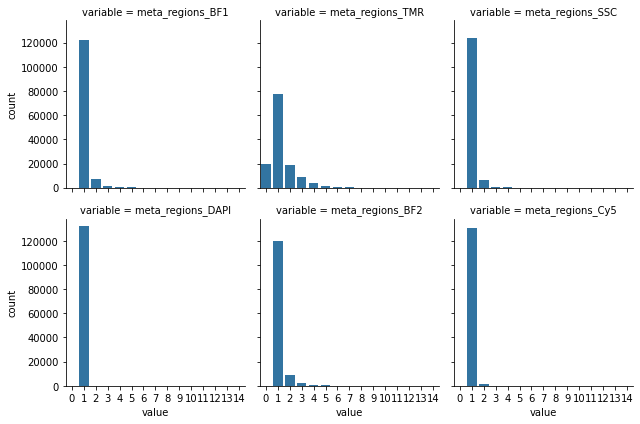

In [10]:
tmp = pandas.melt(df.reset_index(), value_vars=df.filter(regex="regions").columns)
tmp["value"] = tmp["value"].astype(int).astype("category")
grid = seaborn.FacetGrid(data=tmp, col="variable", col_wrap=3)
grid.map_dataframe(seaborn.countplot, x="value")
plt.savefig("number_of_regions.png")

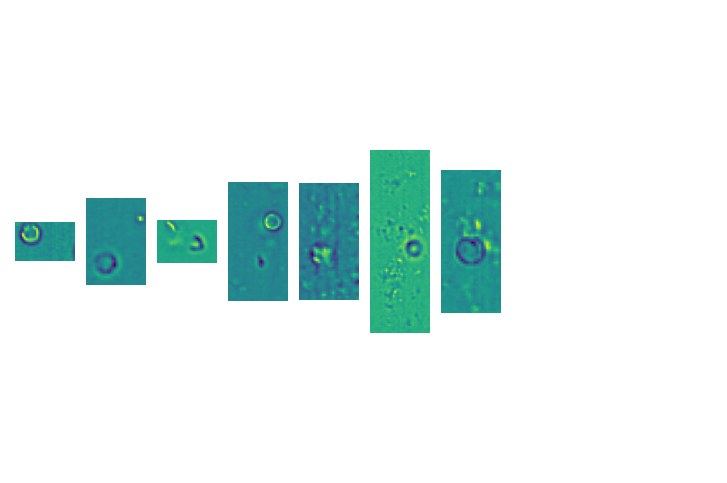

In [10]:
sel = df["meta_regions_BF1"] != 1
plot_gate_zarr(sel, df, maxn=7)

In [11]:
sel = ((df["meta_regions_BF1"] == 1) & (df["meta_regions_BF2"] == 1))

In [12]:
df = df[sel]
df.shape

(116839, 1291)

## NaN values

In [13]:
# show all NaN columns
df.columns[df.isna().all(axis=0)]

Index([], dtype='object')

# All cells must have strictly positive SSC and BF area

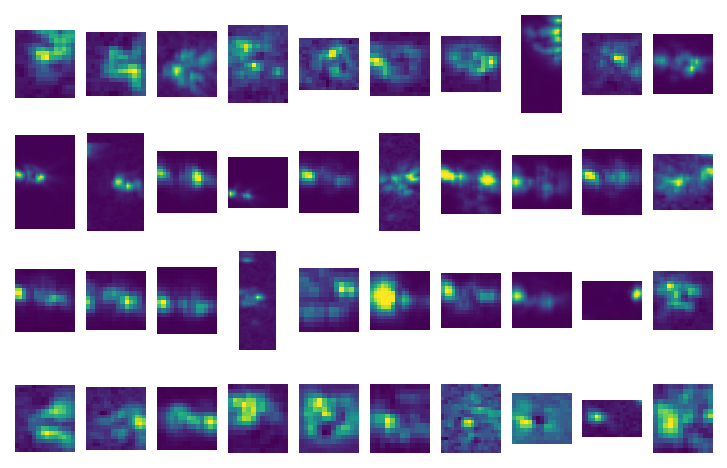

In [14]:
sel1 = df["feat_area_SSC"] == 0
core.plot_gate_zarr(sel1, df, channel=3, maxn=40)

In [15]:
df = df[~sel1]
df.shape

(115383, 1291)

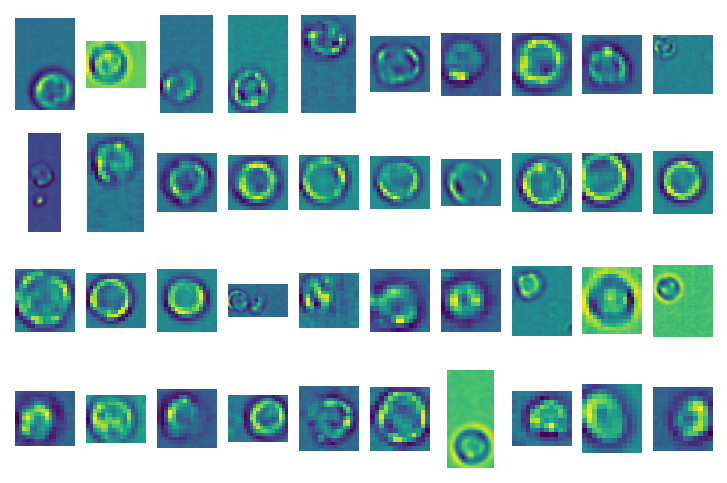

In [16]:
sel1 = df["feat_area_BF1"] == 0
core.plot_gate_zarr(sel1, df, channel=0, maxn=40)

In [17]:
df = df[~sel1]
df.shape

(114835, 1291)

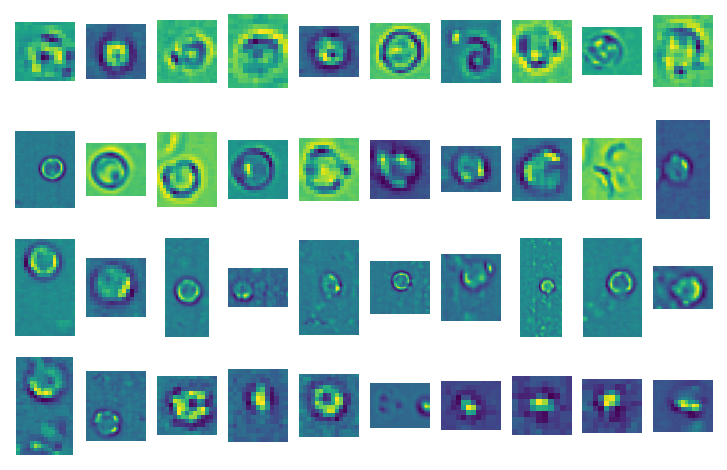

In [18]:
sel1 = df["feat_area_BF2"] == 0
core.plot_gate_zarr(sel1, df, channel=0, maxn=40)

In [19]:
df = df[~sel1]
df.shape

(114621, 1291)

# Detecting multiplets that are missed during segmentation

<AxesSubplot:xlabel='feat_major_axis_length_BF1', ylabel='feat_minor_axis_length_BF1'>

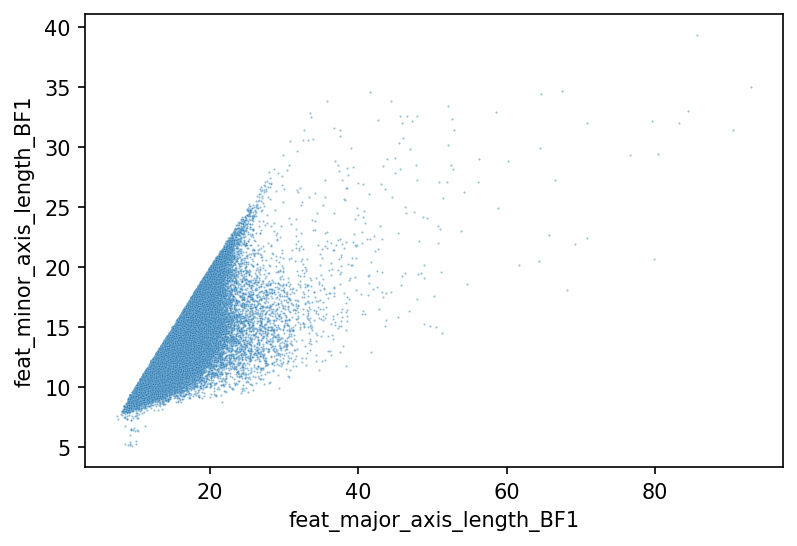

In [20]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(ax=ax, data=df, x="feat_major_axis_length_BF1", y="feat_minor_axis_length_BF1", s=1, alpha=0.5, edgecolors="none")

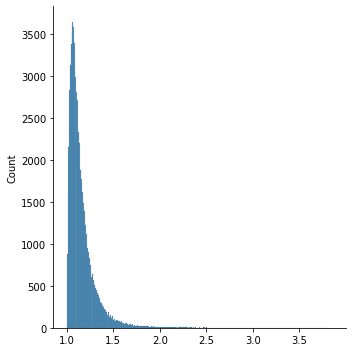

In [21]:
feat_majorminor_ratio = df["feat_major_axis_length_BF1"] / df["feat_minor_axis_length_BF1"]
ax = seaborn.displot(x=feat_majorminor_ratio)

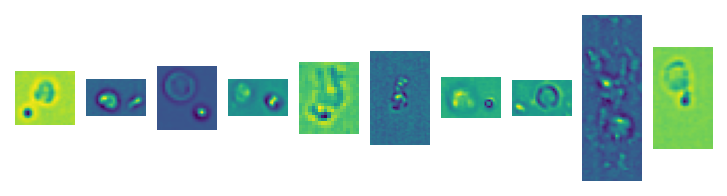

In [22]:
sel1 = feat_majorminor_ratio > 2
plot_gate_zarr(sel1, df, maxn=10)

In [23]:
df = df[~sel1]
df.shape

(114015, 1291)

<AxesSubplot:xlabel='feat_major_axis_length_TMR', ylabel='Count'>

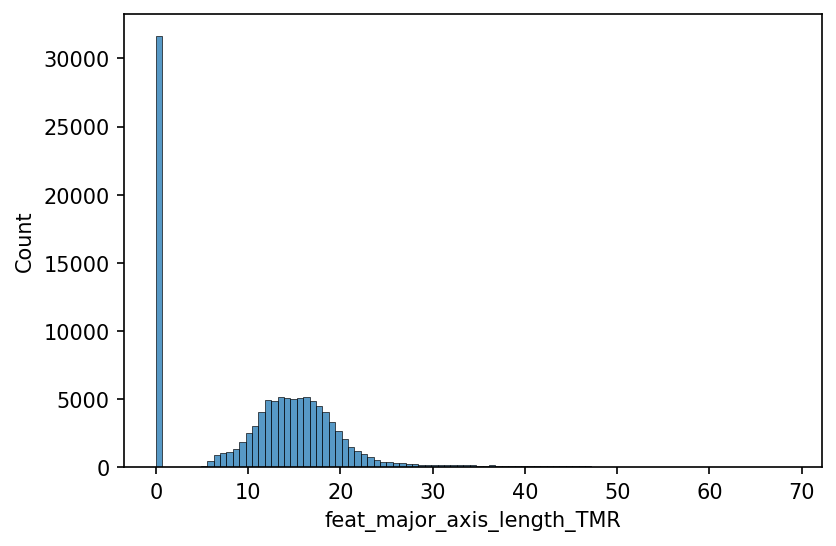

In [24]:
fig, ax = plt.subplots(dpi=150)
seaborn.histplot(ax=ax, data=df, x="feat_major_axis_length_TMR")

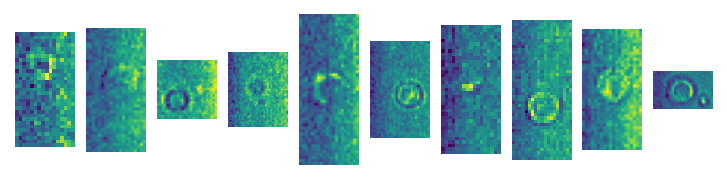

In [26]:
sel1 = df["feat_major_axis_length_TMR"] > 30
plot_gate_zarr(sel1, df, maxn=10, channel=1)

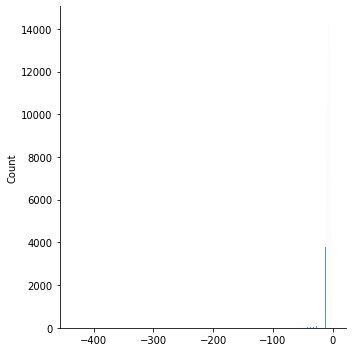

In [25]:
seaborn.displot(data=df["feat_area_BF1"] - df["feat_convex_area_BF1"])

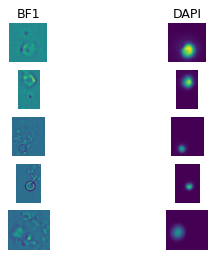

In [26]:
sel1 = (df["feat_area_BF1"] - df["feat_convex_area_BF1"]) < -50
core.plot_gate_zarr_channels([sel1], df, maxn=5, main_channel=1, smooth=1, channel_ind=[0, 4], channel_names=["BF1", "DAPI"])

In [27]:
df = df[~sel1]
df.shape

(113618, 1291)

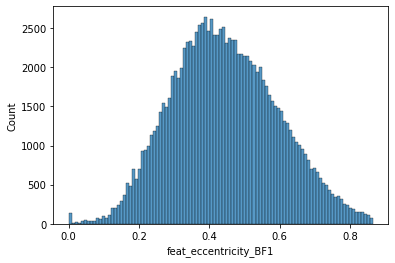

In [28]:
ax = seaborn.histplot(data=df, x="feat_eccentricity_BF1")

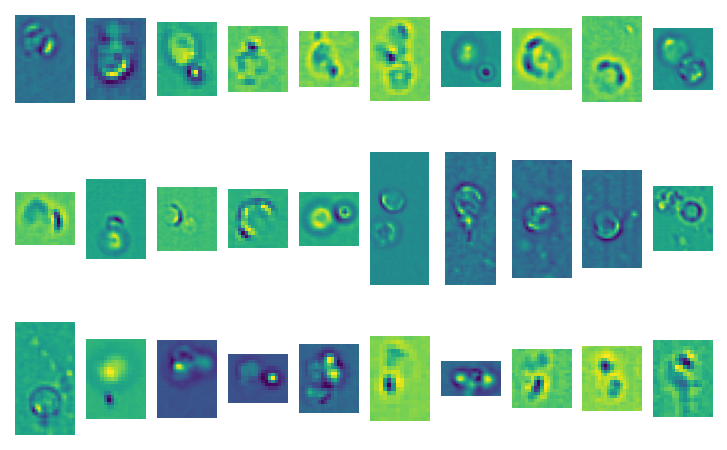

In [29]:
sel1 = df["feat_eccentricity_BF1"] > 0.75
core.plot_gate_zarr(sel1, df, maxn=30)

In [30]:
df = df[~sel1]
df.shape

(110740, 1291)

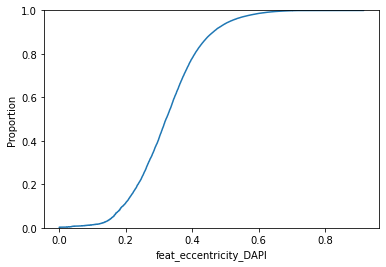

In [31]:
ax = seaborn.ecdfplot(data=df, x="feat_eccentricity_DAPI")

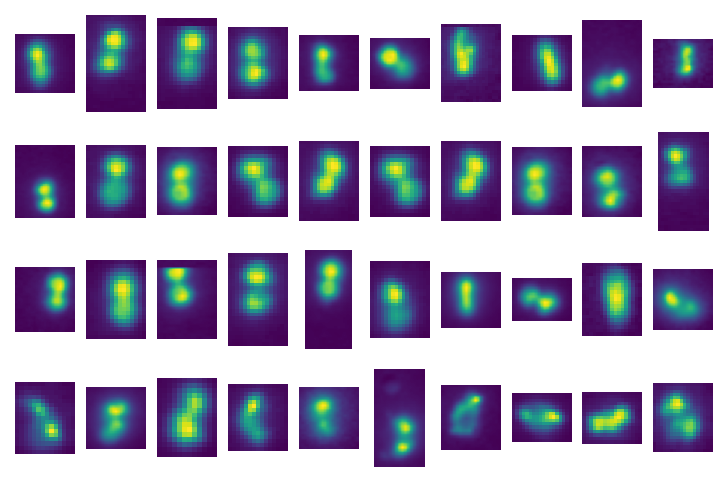

In [32]:
sel1 = df["feat_eccentricity_DAPI"] > 0.7
core.plot_gate_zarr(sel1, df, channel=4, maxn=40)

In [33]:
df = df[~sel1]
df.shape

(110619, 1291)

# Texture features

<AxesSubplot:xlabel='feat_glcm_mean_homogeneity_5_BF1', ylabel='feat_area_BF1'>

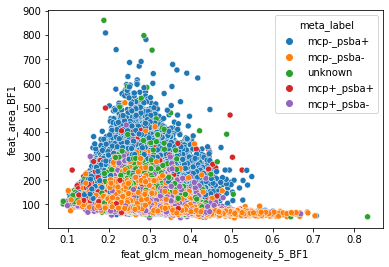

In [34]:
seaborn.scatterplot(data=df, x="feat_glcm_mean_homogeneity_5_BF1", y="feat_area_BF1", hue="meta_label")

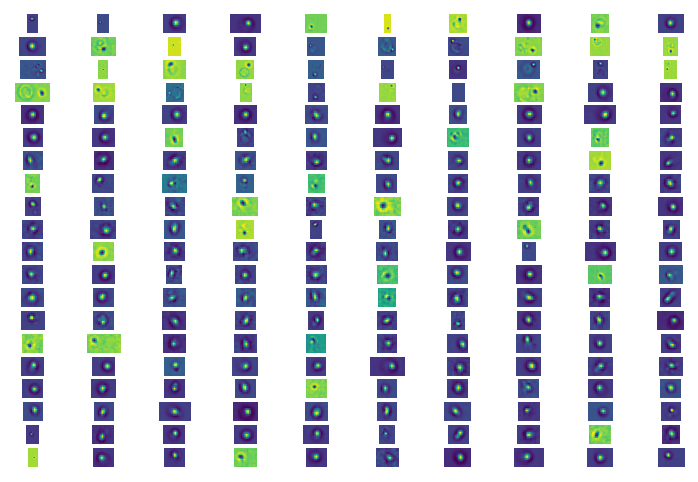

In [37]:
sel1 = df["feat_glcm_mean_homogeneity_5_BF1"] > 0.5
core.plot_gate_zarr(sel1, df)

In [38]:
df[sel1]["meta_label"].value_counts()

mcp-_psba-    176
mcp-_psba+     47
mcp+_psba-     47
unknown        22
mcp+_psba+      5
Name: meta_label, dtype: int64

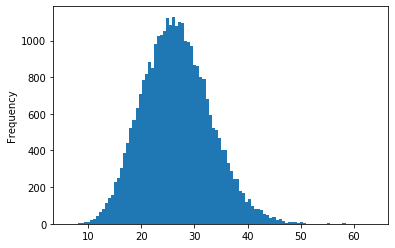

In [54]:
df["feat_glcm_mean_contrast_3_BF1"].plot.hist(bins=100)

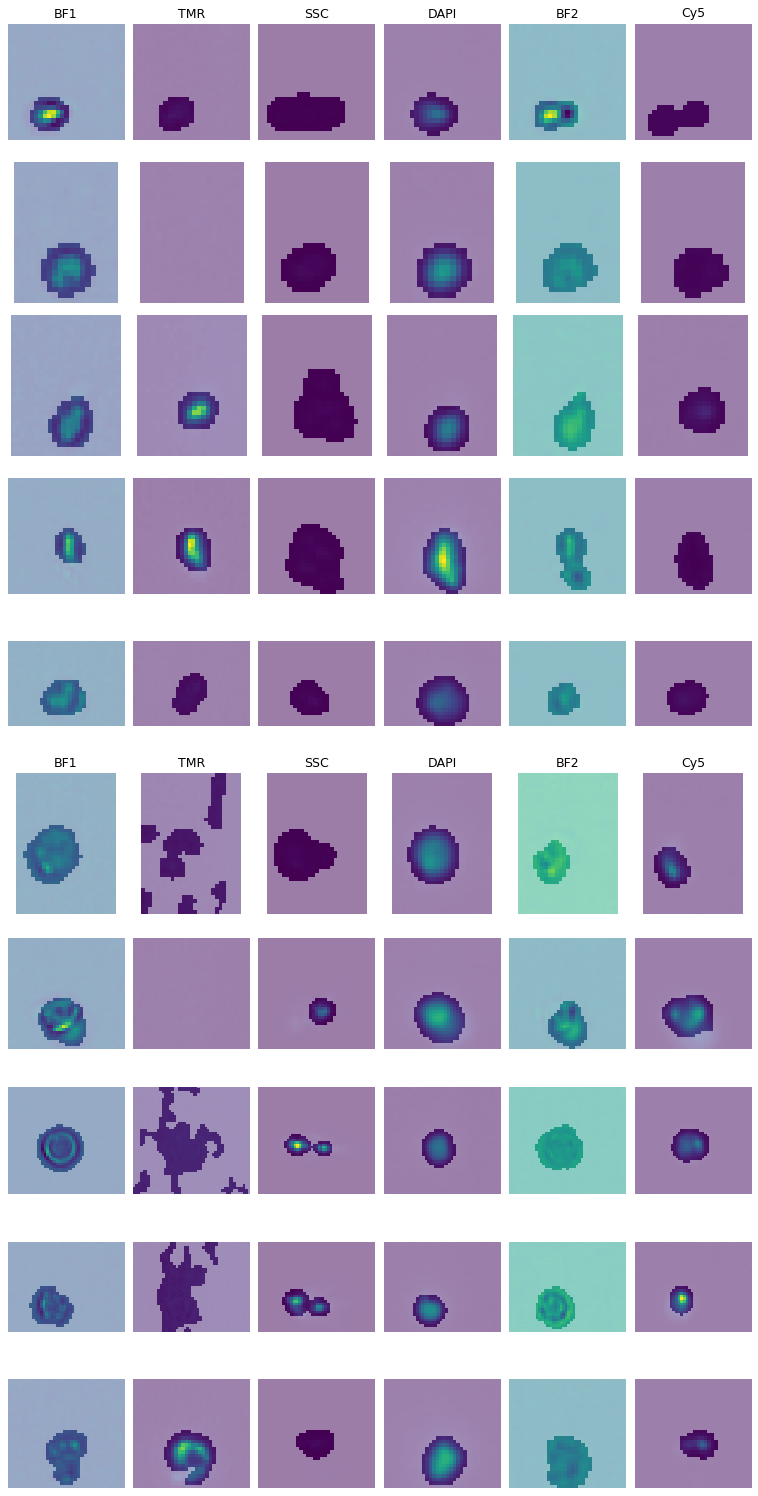

In [347]:
sel1 = df["feat_glcm_mean_contrast_3_BF1"] > 40
sel2 = df["feat_glcm_mean_contrast_3_BF1"] < 10
plot_gate_zarr_channels([sel1, sel2], df, maxn=5, channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "SSC", "DAPI", "BF2", "Cy5"])

# Outlier features or rows

### Normalized variance

In [35]:
norm_var = df.filter(regex="feat").var() / df.filter(regex="feat").mean()

<AxesSubplot:ylabel='Frequency'>

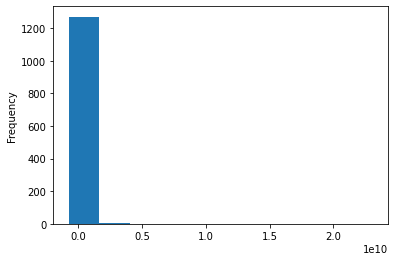

In [36]:
norm_var.plot.hist()

In [37]:
inf_features = norm_var[norm_var.abs() == numpy.inf]

In [38]:
inf_features

Series([], dtype: float64)

In [39]:
for f in inf_features.index:
    s = len(df)
    v = df[f].var()
    while abs(v) == numpy.inf:
        if abs(df[f].min()) > abs(df[f].max()):
            df = df.drop(index=df[f].idxmin())
        else:
            df = df.drop(index=df[f].idxmax())
        v = df[f].var()
    print("Dropped %d rows for %s" % (s-len(df), f))

In [40]:
norm_var[norm_var > 1e10]

feat_moments-3-3_TMR            2.311003e+10
feat_moments_central-3-3_TMR    1.871892e+10
dtype: float64

<AxesSubplot:ylabel='Frequency'>

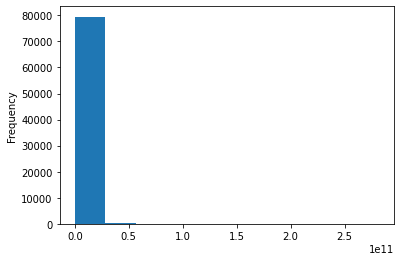

In [41]:
df["feat_moments-3-3_TMR"].plot.hist()

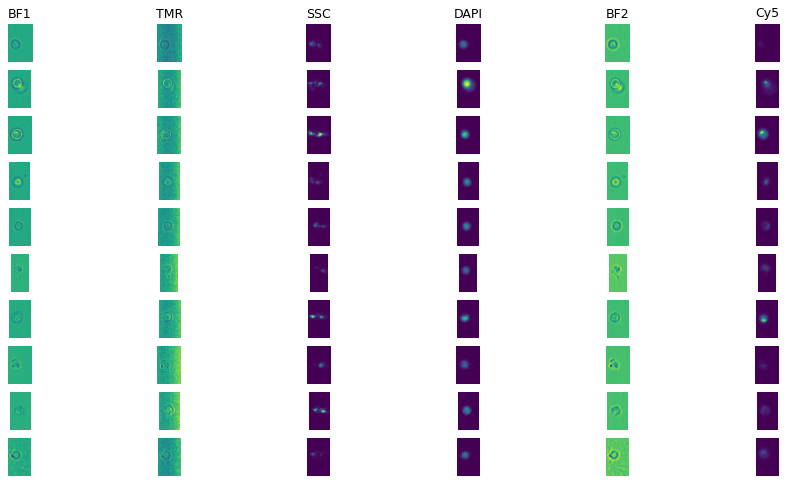

In [42]:
sel1 = df["feat_moments-3-3_TMR"] > 1e11
plot_gate_zarr_channels([sel1], df, maxn=10, channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "SSC", "DAPI", "BF2", "Cy5"])

In [43]:
df = df[~sel1]
df.shape

(110607, 1291)

In [44]:
norm_var = df.filter(regex="feat").var() / df.filter(regex="feat").mean()

<AxesSubplot:ylabel='Frequency'>

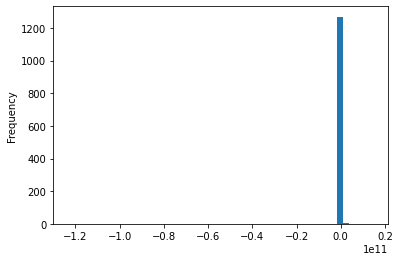

In [45]:
norm_var.plot.hist(bins=50)

In [46]:
norm_var[norm_var > 1e10]

feat_moments-3-3_TMR    1.460356e+10
dtype: float64

<AxesSubplot:ylabel='Frequency'>

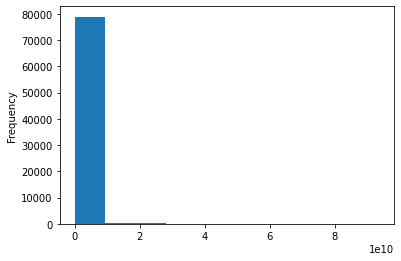

In [47]:
df["feat_moments-3-3_TMR"].plot.hist()

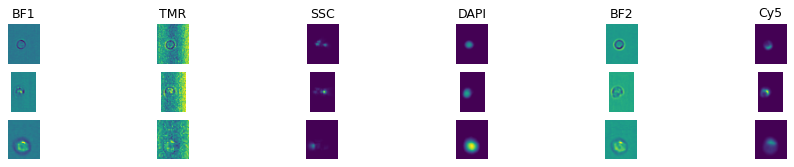

In [48]:
sel1 = df["feat_moments-3-3_TMR"] > 1e10
plot_gate_zarr_channels([sel1], df, maxn=3, channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "SSC", "DAPI", "BF2", "Cy5"])

In [49]:
sel1.sum()

689

In [50]:
df = df[~sel1]
df.shape

(109918, 1291)

In [51]:
norm_var = df.filter(regex="feat").var() / df.filter(regex="feat").mean()

<AxesSubplot:ylabel='Frequency'>

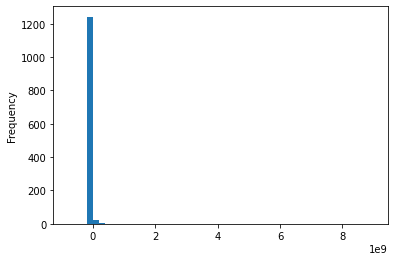

In [52]:
norm_var.plot.hist(bins=50)

In [53]:
norm_var[norm_var > 1e9]

feat_moments-3-3_combined       6.062068e+09
feat_moments-3-3_TMR            2.748309e+09
feat_moments-3-3_SSC            2.103569e+09
feat_moments-3-3_BF2            8.980785e+09
feat_moments_central-3-2_BF2    1.842638e+09
feat_moments-3-3_Cy5            2.578837e+09
dtype: float64

In [54]:
df = df.drop(columns=df.filter(regex="moments-3-3").columns)

In [55]:
norm_var = df.filter(regex="feat").var() / df.filter(regex="feat").mean()

<AxesSubplot:ylabel='Frequency'>

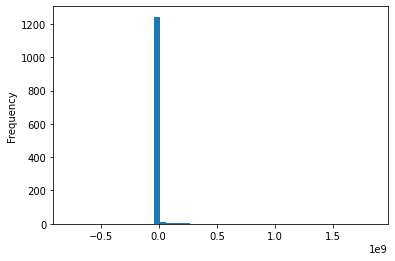

In [56]:
norm_var.plot.hist(bins=50)

In [57]:
norm_var[norm_var > 1e9]

feat_moments_central-3-2_BF2    1.842638e+09
dtype: float64

In [58]:
df = df.drop(columns=df.filter(regex="moments").columns)

In [59]:
norm_var = df.filter(regex="feat").var() / df.filter(regex="feat").mean()

<AxesSubplot:ylabel='Frequency'>

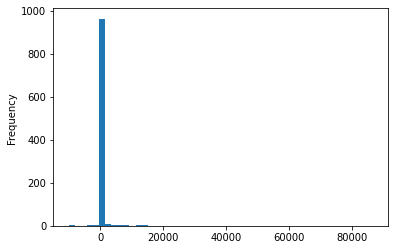

In [60]:
norm_var.plot.hist(bins=50)

In [61]:
norm_var[norm_var > 60000]

feat_sum_SSC                    68821.996708
feat_bgcorr_sum_SSC             78270.404897
feat_combined_sum_SSC           69840.595951
feat_combined_bgcorr_sum_SSC    81396.541682
feat_bgcorr_edge_sum_BF2        86544.550811
dtype: float64

<AxesSubplot:ylabel='Frequency'>

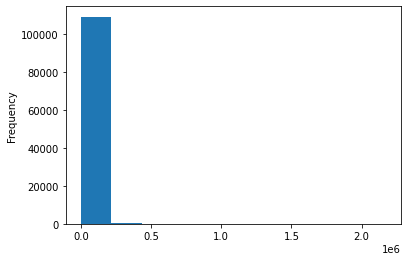

In [62]:
df["feat_sum_SSC"].plot.hist()

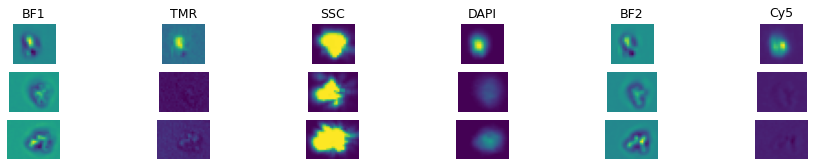

In [63]:
sel1 = df["feat_sum_SSC"] > 400000
plot_gate_zarr_channels([sel1], df, maxn=3, channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "SSC", "DAPI", "BF2", "Cy5"])

### Isolation forest

In [64]:
from sklearn.ensemble import IsolationForest

In [65]:
iso = IsolationForest(n_estimators=100, random_state=0, n_jobs=5, contamination=0.05)
iso.fit(
    df.filter(regex="feat")
    .fillna(0)
    .clip(lower=numpy.finfo('float32').min, upper=numpy.finfo('float32').max)  # iso requires everything to fit in float32
)

/data/gent/420/vsc42015/python_lib_doduo/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.05, n_jobs=5, random_state=0)

In [66]:
pred = iso.predict(
    df.filter(regex="feat")
    .fillna(0)
    .clip(lower=numpy.finfo('float32').min, upper=numpy.finfo('float32').max)  # iso requires everything to fit in float32
)

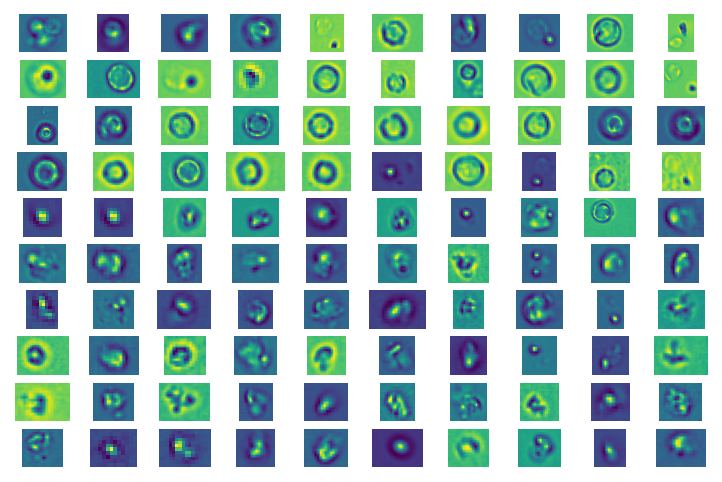

In [67]:
plot_gate_zarr(pred == -1, df, maxn=100)

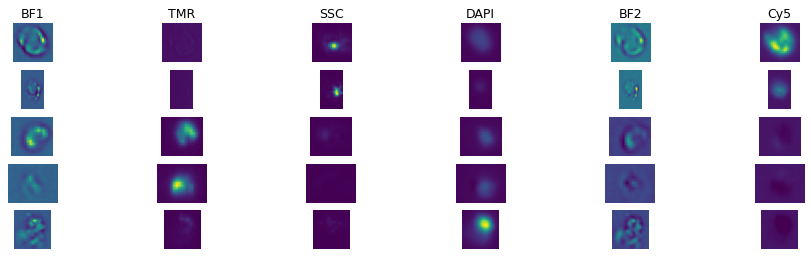

In [68]:
plot_gate_zarr_channels([pred == -1], df, maxn=5, smooth=1, channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "SSC", "DAPI", "BF2", "Cy5"])

In [69]:
numpy.unique(pred, return_counts=True)

(array([-1,  1]), array([  5496, 104422]))

# Feature distributions

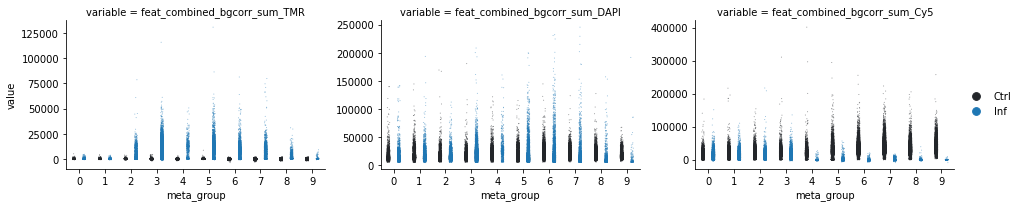

In [70]:
melted_df = pandas.melt(df.reset_index(), id_vars=["meta_type", "meta_group", "meta_replicate"], value_vars=df.filter(regex="feat_combined_bgcorr_sum_(TMR|DAPI|Cy5)").columns)
grid = seaborn.FacetGrid(data=melted_df, col="variable", sharey=False, aspect=1.5)
grid.map_dataframe(seaborn.stripplot, x="meta_group", y="value", hue="meta_type", dodge=True, size=1, alpha=0.5)
grid.add_legend()

In [71]:
for k, gdf in df.groupby("meta_group"):
    gdf = gdf[[
        "feat_combined_bgcorr_sum_TMR", 
        "feat_combined_bgcorr_sum_DAPI", 
        "feat_combined_bgcorr_sum_Cy5"
    ]]
    transf = flowutils.transforms.logicle(gdf.values, w=1.3, t=200000, m=4.5, channel_indices=None)
    df.loc[(slice(None), slice(None), slice(None), slice(None), k), [
        "feat_combined_bgcorr_sum_logicle_TMR",
        "feat_combined_bgcorr_sum_logicle_DAPI", 
        "feat_combined_bgcorr_sum_logicle_Cy5"
    ]] = transf

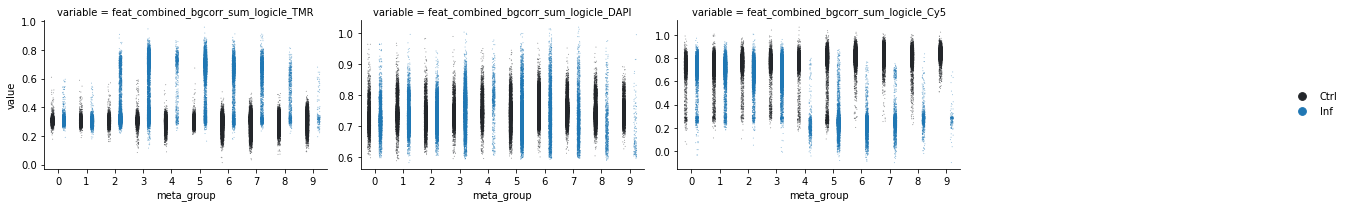

In [72]:
melted_df = pandas.melt(df.reset_index(), id_vars=["meta_type", "meta_group", "meta_replicate"], value_vars=df.filter(regex="feat_combined_bgcorr_sum_logicle_(TMR|DAPI|Cy5)").columns)
grid = seaborn.FacetGrid(data=melted_df, col="variable", col_wrap=4, sharey=False, aspect=1.5)
grid.map_dataframe(seaborn.stripplot, x="meta_group", y="value", hue="meta_type", dodge=True, size=1, alpha=0.5)
grid.add_legend()

In [73]:
df[pred == -1].index.get_level_values("meta_type").value_counts()

Inf     3231
Ctrl    2265
Name: meta_type, dtype: int64

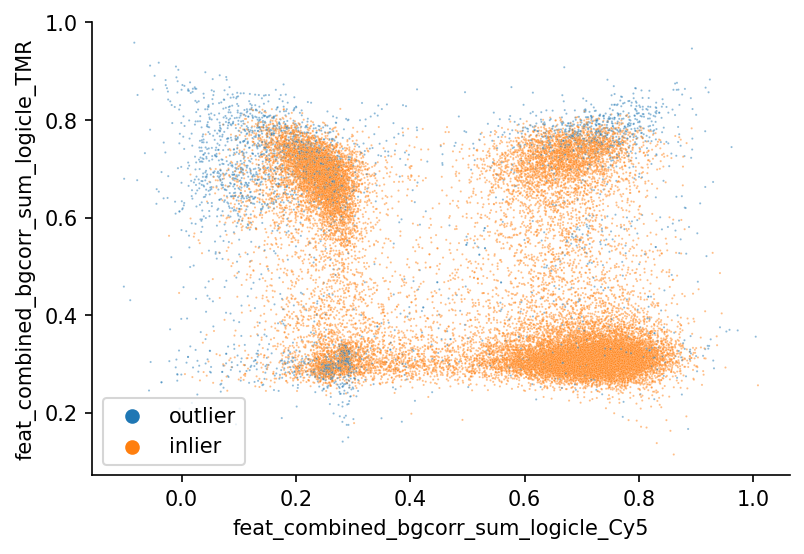

In [74]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(
    data=df.loc["Inf"], 
    x="feat_combined_bgcorr_sum_logicle_Cy5", 
    y="feat_combined_bgcorr_sum_logicle_TMR", 
    hue=numpy.where(pred[numpy.nonzero(df.index.get_level_values(level="meta_type") == "Inf")] == 1, "inlier", "outlier"), 
    s=1, alpha=0.5, ax=ax
)
seaborn.despine(fig)

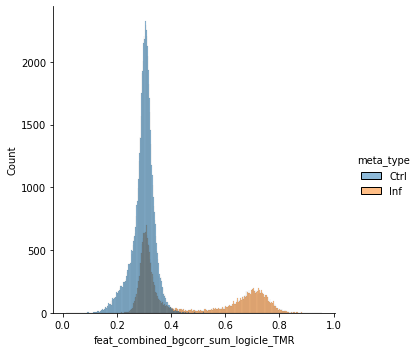

In [53]:
seaborn.displot(data=df, x="feat_combined_bgcorr_sum_logicle_TMR", hue="meta_type")

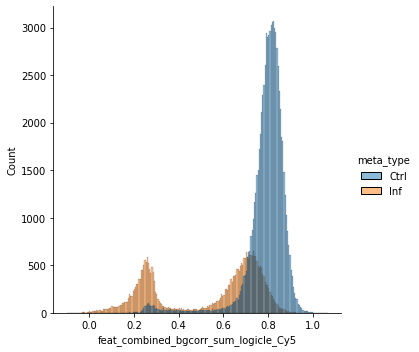

In [54]:
seaborn.displot(data=df, x="feat_combined_bgcorr_sum_logicle_Cy5", hue="meta_type")

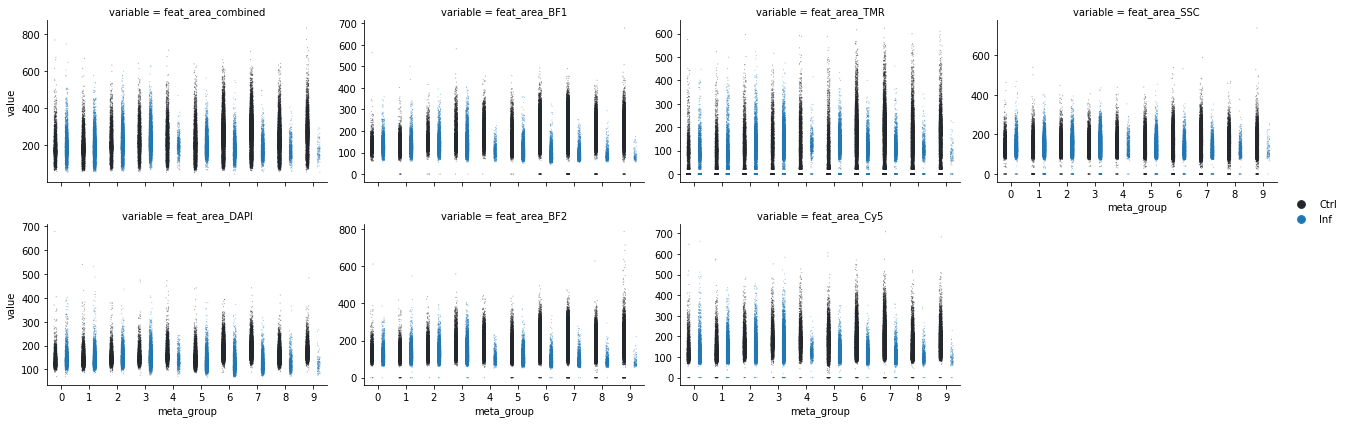

In [18]:
melted_df = pandas.melt(df.reset_index(), id_vars=["meta_type", "meta_group", "meta_replicate"], value_vars=df.filter(regex="^feat_area_.*").columns)
grid = seaborn.FacetGrid(data=melted_df, col="variable", sharey=False, aspect=1.5, col_wrap=4)
grid.map_dataframe(seaborn.stripplot, x="meta_group", y="value", hue="meta_type", dodge=True, size=1, alpha=0.5)
grid.add_legend()

In [75]:
df = df[pred == 1]

# Low variance features

In [76]:
v = df.filter(regex="feat").var()

In [77]:
v.isna().sum()

0

In [78]:
low_var = df.filter(regex="feat").columns[df.filter(regex="feat").var() < 0.001]

In [79]:
low_var

Index(['feat_euler_number_combined', 'feat_solidity_combined',
       'feat_euler_number_BF1', 'feat_solidity_BF1', 'feat_euler_number_SSC',
       'feat_solidity_SSC', 'feat_euler_number_DAPI', 'feat_solidity_DAPI',
       'feat_extent_DAPI', 'feat_euler_number_BF2',
       ...
       'feat_glcm_mean_ASM_3_Cy5', 'feat_glcm_mean_ASM_5_Cy5',
       'feat_glcm_std_ASM_3_Cy5', 'feat_glcm_std_ASM_5_Cy5',
       'feat_combined_glcm_std_homogeneity_3_Cy5',
       'feat_combined_glcm_std_homogeneity_5_Cy5',
       'feat_combined_glcm_std_energy_3_Cy5',
       'feat_combined_glcm_std_energy_5_Cy5',
       'feat_combined_glcm_std_ASM_3_Cy5', 'feat_combined_glcm_std_ASM_5_Cy5'],
      dtype='object', length=111)

In [80]:
df = df.drop(columns=low_var)

# Export

In [81]:
numpy.save("/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/results/scip/202202071958/indices/index_v5.npy", df.index.values)

In [82]:
numpy.save("/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/results/scip/202202071958/indices/columns_v5.npy", df.columns.values)

In [66]:
numpy.save("/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/results/scip/202202071958/indices/iso_outliers_v4.npy", df[pred == -1].index.values)